# Challenge Deep Learning

L'objectif de ce challenge est de proposer une méthode de classification, basée sur des réseaux de neurones, permettant de classer des images issues de Google Quickdraw (https://quickdraw.withgoogle.com/data).
Le jeu de données proposé comprend 5 classes balancées, avec 15000 exemples d'apprentissage et 5000 exemples de validation : des paniers, des yeux, des lunettes, des lapins et des mains.

Vous pouvez utiliser tout algorithme qui vous semble pertinent (PMC, CNN,), en faisant varier les données d'entrée (normalisation, augmentation de données,...), les paramètres des réseaux considérés (fonction objectif, optimiseur, dropout, learning rate, taille des batchs...)

Bien sûr, pour valider votre travail, nous ferons tourner le code en local, sur la base originale que nous conservons, pour voir si les résultats que vous proposez sont reproductibles. 

Le compte-rendu sera effectué sur un notebook jupyter, dans lequel vous reporterez votre méthodologie en markdown, et vos codes en Python. Vous expliquerez votre démarche, justifierez vos choix, commenterez vos expérimentations et vos résultats.

La notation sera construite de la manière suivante : 
- 12 points sur le compte-rendu
- 8 points seront accordés sur un classement par le taux de reconnsaissance des objets de la base de test. Les binômes seront classés par taux de reconnaissance décroissant, les premiers ayant 8 points accordés, les autres binômes ayant une note suivant une décroissance linéaire.

Le notebook sera déposé sur la plateforme moodle du cours.

## Imports

In [ ]:
%matplotlib inline

import os
from sklearn.utils import shuffle
import tensorflow as tf
import pandas as pd
import numpy as np
import time
import cv2 
from PIL import Image
import glob
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization, MaxPool2D
from tensorflow.keras.optimizers import Adam
import visualkeras
from tensorflow.keras.callbacks import EarlyStopping

## Données

In [ ]:
DATADIR = "C:/Users/abder/OneDrive/Bureau/challengeDL/images/"
classes = ["basket","eye","binoculars","rabbit","hand"]
num_classes = len(classes)
train = pd.read_csv('train.csv')
valid = pd.read_csv('valid.csv')

In [ ]:
valid = shuffle(valid)
train = shuffle(train)

train.head()

,image_name,relative_path,class_label
59418,rabbit_054217.png,rabbit/rabbit_054217.png,3
49529,rabbit_016292.png,rabbit/rabbit_016292.png,3
50111,rabbit_071696.png,rabbit/rabbit_071696.png,3
544,basket_042792.png,basket/basket_042792.png,0
8247,basket_108756.png,basket/basket_108756.png,0


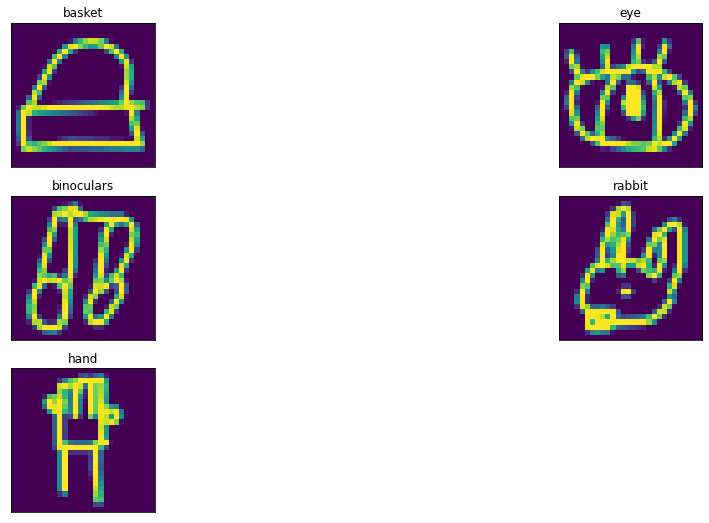

In [ ]:
plt.figure(figsize=(18,9))
for i in range(0,5):
    ax= plt.subplot(3,2 ,i+1)
    mydata = pd.read_csv("train.csv",skiprows = [1], nrows=1)
    im = Image.open('images/'+classes[i]+'/'+ os.listdir("images/"+classes[i])[0])
    fig=ax.imshow(im)
    plt.title(classes[i])
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
plt.show()    


### Parmis les réseaux de neuronnes les plus performants au niveau de la classification d'images, on retouve les réseaux convolutionnel. Pour cela, nous avons commencé par ce type de réseaux afin de classifier nos images.  

### La première étape est de définir les paramètres de notre modèle 
### Avant de fixer les paramètres ci-dessous, nous avons varié les valeurs du learning rate (lr) ainsi que les valeurs du dropout avant de fixer ces deux derniers sur les valeurs suivantes car c'est celles qui nous ont permis d'avoir le meilleur score d'apprentissage



In [ ]:
IMG_SIZE = 28
lr = 0.001
num_epochs = 25
batch_size = 200
dropout = 0.3

### Ensuite on charge les données d'entrainement ainsi que les données de validation

In [ ]:
x_train_cnn = []
y_train_cnn = []
for i in range(len(train)):
    path = DATADIR + train['relative_path'][i]
    x_train_cnn.append(cv2.imread(path, cv2.IMREAD_GRAYSCALE))
    y_train_cnn.append(train['class_label'][i])

In [ ]:
x_test_cnn = []
y_test_cnn = []
for i in range(len(valid)):
    path = DATADIR + valid['relative_path'][i]
    x_test_cnn.append(cv2.imread(path, cv2.IMREAD_GRAYSCALE))
    y_test_cnn.append(valid['class_label'][i])

### Nous devons également s'assurer que les images sont sous la forme  28x28, ce qui donne au réseau de neurones des informations supplémentaires par rapport à un vecteur de taille 784x1.

In [ ]:
x_train_cnn = np.array(x_train_cnn).reshape(-1, IMG_SIZE, IMG_SIZE, 1).astype('float32')
x_test_cnn = np.array(x_test_cnn).reshape(-1, IMG_SIZE, IMG_SIZE, 1).astype('float32')
y_train_cnn = np.array(y_train_cnn)
y_test_cnn = np.array(y_test_cnn)

### Les valeurs des pixel varie en général entre 0 et 255. Il est presque toujours judicieux d'effectuer une mise à l'échelle des valeurs d'entrée lors de l'utilisation de modèles de réseau de neurones. Étant donné que l'échelle est bien connue et se comporte bien, nous pouvons très rapidement normaliser les valeurs des pixel entre 0 et 1 en divisant chaque valeur par la valeur maximale d'un pixel et qui est de 255

In [ ]:
x_train_cnn = x_train_cnn / 255.0
x_test_cnn = x_test_cnn / 255.0

### Présentation du modèle 


Après avoir préparé nos données et fixé nos paramètres.Nous sommes maintenant prêts à créer notre modèle. 


Le modèle comporte les 9 couches suivantes:

- Couche convolutive.
- Couche de pooling prenant le maximum sur 2 * 2 patchs.
- Couche convolutive avec 15 cartes d'entités de taille 3 × 3.
- Couche De pooling prenant le maximum sur 2 * 2 patchs.
- Couche Dropout avec une probabilité de 30%.
- Couche Flatten
- Couche Dense avec 128 neurones et activation du redresseur.
- Couche Dense avec 50 neurones et activation du redresseur.
- Couche de sortie.

Adam est un optimiseur utilisé pour modifier les attributs de notre réseau de neurones tels que les poids et le taux d'apprentissage afin de réduire les pertes.

Afin de faciliter l'utilisation du modèle nous avons défini une fonction qui représentera le modèle qu'on veut entrainer

In [ ]:
## Premier modèle à entrainer
def cnn_model():
    model = Sequential()
    model.add(Conv2D(30, (5, 5), input_shape=(IMG_SIZE, IMG_SIZE, 1), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(15, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    
    opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    
    model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

Dans le but de comparer les performances de deux CNN différents, nous avous créé un second modèle plus compliqué que le premier. Nous avons ajouté une couche BatchNormalisation qui a pour but de rendre  notre modèle plus rapide et plus stable grâce à la normalisation de la couche d'entrée par recentrage et 
re-mise à l'échelle.

In [ ]:
def cnn_model_2():
    model = Sequential()

    model.add(Conv2D(filters = 32, kernel_size= (4,4), padding = 'same', input_shape = (28,28,1), activation= 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Conv2D(filters = 64, kernel_size= (4,4), padding = 'same', input_shape = (28,28,1), activation= 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(dropout))
    model.add(BatchNormalization())
    model.add(Conv2D(filters = 128, kernel_size= (4,4), padding = 'same', input_shape = (28,28,1), activation= 'relu'))
    model.add(Conv2D(filters = 128, kernel_size= (4,4), padding = 'same', input_shape = (28,28,1), activation= 'relu'))
    model.add(Dropout(dropout))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(num_classes, activation='softmax'))

    opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

    model.compile(optimizer = opt, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

    return model

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_train_cnn, y_train_cnn, test_size=0.2, random_state=0)

Afin d'éviter le sur-apprentissage durant l'entrainement de notre réseau de neuronnes , nous avons choisi d'utiliser l'EarlyStopping qui nous permettera d'arrêter l'entrainement une fois que les performances du modèle ne s'améliorent plus 

## Maintenant , on commence l'entrainement de notre premier modèle 

In [ ]:
model = cnn_model()
early_stop = EarlyStopping(monitor = 'val_loss', patience = 18)

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 24, 24, 30)        780       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 30)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 15)        4065      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 15)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5, 15)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 375)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)              

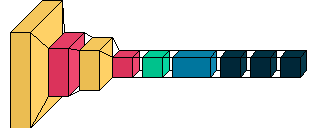

In [ ]:
visualkeras.layered_view(model)

In [ ]:
hist = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=num_epochs, batch_size=batch_size, callbacks=[early_stop])
# Final evaluation of the model
scores = model.evaluate(x_test, y_test, verbose=0)
print('Final CNN accuracy: ', scores[1])

Epoch 1/25
300/300 [==============================] - 30s 96ms/step - loss: 0.8656 - accuracy: 0.6838 - val_loss: 0.3417 - val_accuracy: 0.8925
Epoch 2/25
300/300 [==============================] - 27s 91ms/step - loss: 0.3741 - accuracy: 0.8811 - val_loss: 0.2704 - val_accuracy: 0.9135
Epoch 3/25
300/300 [==============================] - 28s 92ms/step - loss: 0.2966 - accuracy: 0.9043 - val_loss: 0.2352 - val_accuracy: 0.9255
Epoch 4/25
300/300 [==============================] - 28s 92ms/step - loss: 0.2623 - accuracy: 0.9129 - val_loss: 0.2082 - val_accuracy: 0.9321
Epoch 5/25
300/300 [==============================] - 27s 91ms/step - loss: 0.2322 - accuracy: 0.9236 - val_loss: 0.1996 - val_accuracy: 0.9346
Epoch 6/25
300/300 [==============================] - 27s 91ms/step - loss: 0.2179 - accuracy: 0.9272 - val_loss: 0.1929 - val_accuracy: 0.9356
Epoch 7/25
300/300 [==============================] - 26s 87ms/step - loss: 0.2048 - accuracy: 0.9314 - val_loss: 0.1813 - val_accuracy:

#### On teste la performance du modèle sur les données de validation

In [ ]:
from sklearn.metrics import accuracy_score

y_pred_cnn = model.predict_classes(x_test_cnn, batch_size=32, verbose=0)
acc_cnn = accuracy_score(y_test_cnn, y_pred_cnn)
print ('CNN accuracy: ',acc_cnn)

c:\users\abder\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


CNN accuracy:  0.9466


## Nous avons réussi à obtenir un score de 94,66% sur les données de validation grace à ce premier modèle.  On constate une légère diminution entre la performance sur les données d'entrainements et la performance sur les données de validation. 

In [ ]:
#sauvegarder le modèle
model.save("model.h5")

782/782 [==============================] - 6s 8ms/step - loss: 0.1742 - accuracy: 0.9466


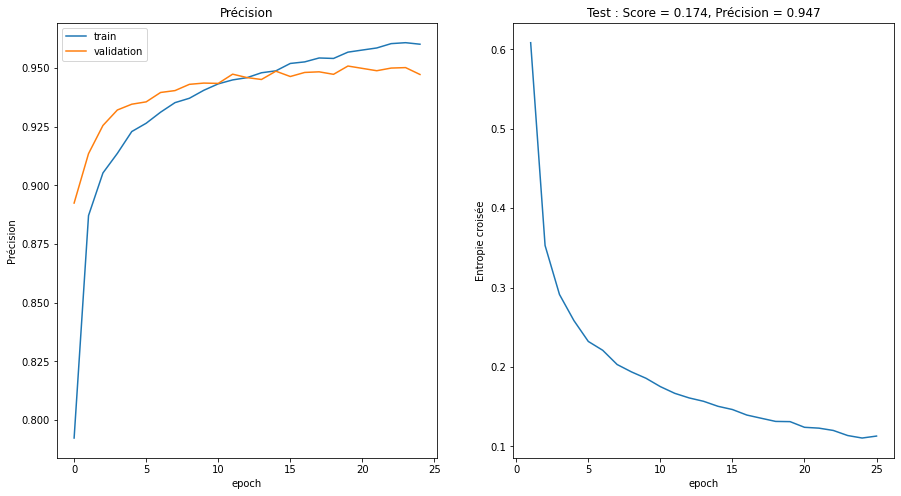

<Figure size 432x288 with 0 Axes>

In [ ]:
score = model.evaluate(x_test_cnn, y_test_cnn, verbose=1)
plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Précision')
plt.ylabel('Précision')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')

plt.subplot(1,2,2)
x = list(range(1,num_epochs+1))
l = hist.history['loss']
plt.xlabel('epoch')
plt.ylabel('Entropie croisée')
plt.title("Test : Score = {0:5.3f}, Précision = {1:5.3f}".format(score[0], score[1]))
plt.plot(x,l)
plt.show()
plt.tight_layout()


### Comme prévu , nous avons une légère diminution entre la performance du modèle sur les données d'entrainements et sur les données de validation. 
### Afin de mieux voir cette performance, nous avons choisi de vérifier ça grace à une matrice de confusion


<AxesSubplot:>

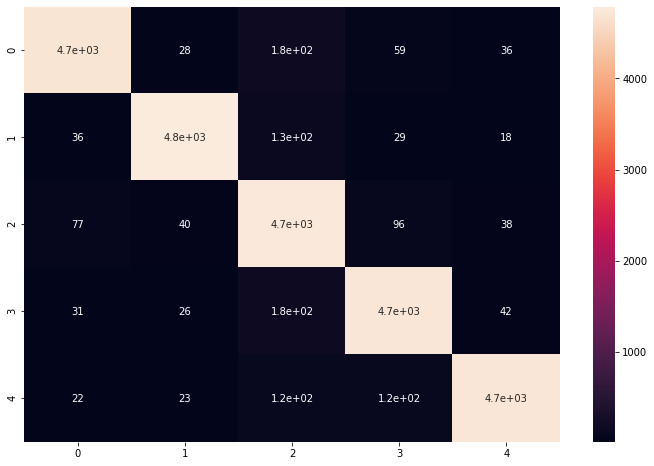

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
plt.figure(figsize = (12, 8))
sns.heatmap(confusion_matrix(y_test_cnn, y_pred_cnn), annot=True)

### Nous avons globalement réussi à avoir de bons résultats d'après la matrice de confusion.Pourtant, nous avons décidé d'entrainer un deuxième modèle afin de voir s'il est possible d'obtenir de meilleurs résultats.   

### Entrainement du deuxième modèle

In [ ]:
model_2 = cnn_model_2()

model_2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 28, 28, 32)        544       
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 64)        32832     
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 64)         

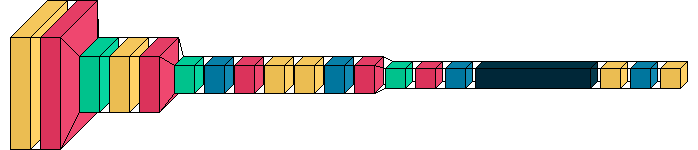

In [ ]:
visualkeras.layered_view(model_2)

In [ ]:
hist_2 = model_2.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=num_epochs, batch_size=batch_size, callbacks=[early_stop])
# Final evaluation of the model
scores_2 = model.evaluate(x_test, y_test, verbose=0)
print('Final CNN accuracy: ', scores_2[1])

Epoch 1/25
300/300 [==============================] - 266s 884ms/step - loss: 0.6502 - accuracy: 0.7782 - val_loss: 1.6179 - val_accuracy: 0.1976
Epoch 2/25
300/300 [==============================] - 279s 931ms/step - loss: 0.2245 - accuracy: 0.9248 - val_loss: 0.6709 - val_accuracy: 0.7122
Epoch 3/25
300/300 [==============================] - 298s 993ms/step - loss: 0.1791 - accuracy: 0.9411 - val_loss: 0.1537 - val_accuracy: 0.9485
Epoch 4/25
300/300 [==============================] - 254s 847ms/step - loss: 0.1519 - accuracy: 0.9489 - val_loss: 0.2330 - val_accuracy: 0.9297
Epoch 5/25
300/300 [==============================] - 266s 887ms/step - loss: 0.1364 - accuracy: 0.9543 - val_loss: 0.1555 - val_accuracy: 0.9492
Epoch 6/25
300/300 [==============================] - 251s 838ms/step - loss: 0.1225 - accuracy: 0.9578 - val_loss: 0.1421 - val_accuracy: 0.9521
Epoch 7/25
300/300 [==============================] - 285s 950ms/step - loss: 0.1123 - accuracy: 0.9621 - val_loss: 0.1472 -

In [ ]:
y_pred_cnn_2 = model_2.predict_classes(x_test_cnn, batch_size=32, verbose=0)
acc_cnn_2 = accuracy_score(y_test_cnn, y_pred_cnn_2)
print ('CNN accuracy: ',acc_cnn_2)

c:\users\abder\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


CNN accuracy:  0.95812


## Nous avons réussi à obtenir un score de 95,81% sur les données de validation grace à ce deuxième modèle, ce qui est plus important que le premier modèle. 

782/782 [==============================] - 40s 51ms/step - loss: 0.1553 - accuracy: 0.9581


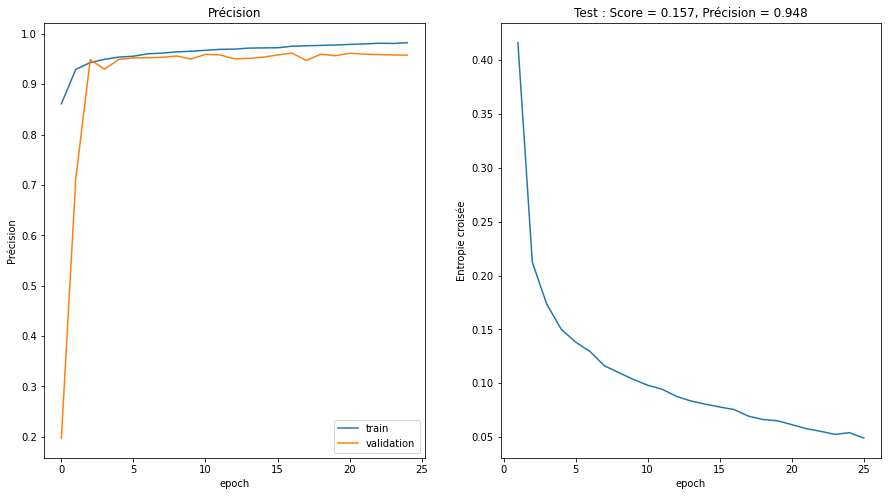

<Figure size 432x288 with 0 Axes>

In [ ]:
score = model_2.evaluate(x_test_cnn, y_test_cnn, verbose=1)
plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
plt.plot(hist_2.history['accuracy'])
plt.plot(hist_2.history['val_accuracy'])
plt.title('Précision')
plt.ylabel('Précision')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')

plt.subplot(1,2,2)
x = list(range(1,num_epochs+1))
l = hist_2.history['loss']
plt.xlabel('epoch')
plt.ylabel('Entropie croisée')
plt.title("Test : Score = {0:5.3f}, Précision = {1:5.3f}".format(scores_2[0], scores_2[1]))
plt.plot(x,l)
plt.show()
plt.tight_layout()


<AxesSubplot:>

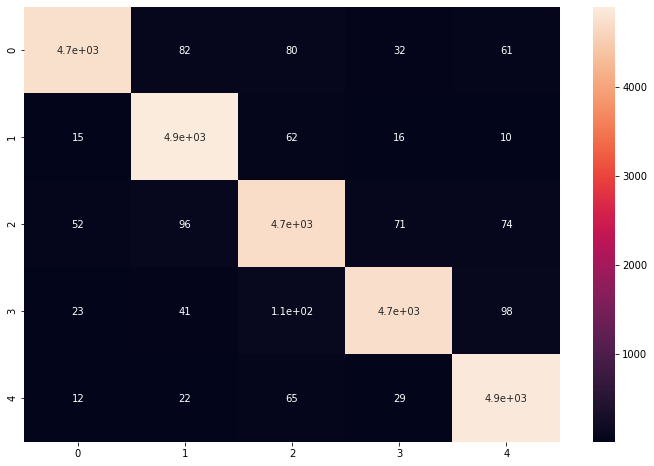

In [ ]:
plt.figure(figsize = (12, 8))
sns.heatmap(confusion_matrix(y_test_cnn, y_pred_cnn_2), annot=True)

### Grace à cette matrice de confusion , on peut remarquer que ce modèle est plus performant que le premier modèle que nous avons entrainé.
### Sur le premier modèle , au niveau de la 3ème classe nous avons obtenu un grand nombre de mauvaises classifications.
## Avec son score qui est plus important, le deuxième modèle nous parrait plus stable et plus perfomant, pour cela nous avons choisi de le garder pour notre classification.

In [ ]:
model_2.save("model_2.h5")